In [1]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
from scipy.stats import poisson

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.ticker import MultipleLocator, MaxNLocator
import matplotlib.gridspec as gridspec
import seaborn as sns

import pymc as pm
import arviz as az
import pytensor.tensor as pt
from pytensor.tensor.special import gammaln

from tqdm.autonotebook import tqdm

plt.rcParams.update({
    "mathtext.fontset": "stix",
    "font.family": "STIXGeneral",
    "legend.fontsize": 12,
    "legend.title_fontsize": 14,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "axes.titlesize": 16,
    "axes.labelsize": 18,
})
mpl.rcParams['animation.embed_limit'] = 2000

/var/folders/rr/16wv6ts1785fz6_2qhr5bc2m0000gn/T/ipykernel_9151/3930498230.py:20: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


## **One parameter ($\lambda$)** 

**One parameter ($\lambda$)** synthetic data generation

In [6]:
class insilico_experiment_1P:
    
    def __init__(
        self,
        kill_lambda: float = 3.0,
        Num_killers_obs: int = 300,
        random_seed: int = 66
    ):
        self.kill_lambda = kill_lambda
        self.Num_killers_obs = Num_killers_obs
        self.random_seed = random_seed
        
        self.kills = self._generate_data()
    
    def _generate_data(self):
        rng = np.random.default_rng(self.random_seed)
        kills = rng.poisson(self.kill_lambda, self.Num_killers_obs)
        return kills
    
    def regenerate(self, new_seed: int = None):
        if new_seed is not None:
            self.random_seed = new_seed
        self.kills = self._generate_data()
    def get_summary(self):
        return {
            "kill_lambda": self.kill_lambda,
            "kills": self.kills,
            "killer_number": self.Num_killers_obs
        }

In [8]:
NO_CELL = 300

lambda_list = [0.5, 1.2, 2]
experiment = {}
for i, lambda_value in enumerate(lambda_list):
    experiment[i] = insilico_experiment_1P(
        kill_lambda=lambda_value,
        Num_killers_obs=NO_CELL,
        random_seed=None
    )

/var/folders/rr/16wv6ts1785fz6_2qhr5bc2m0000gn/T/ipykernel_9151/2929282866.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('YlGnBu')


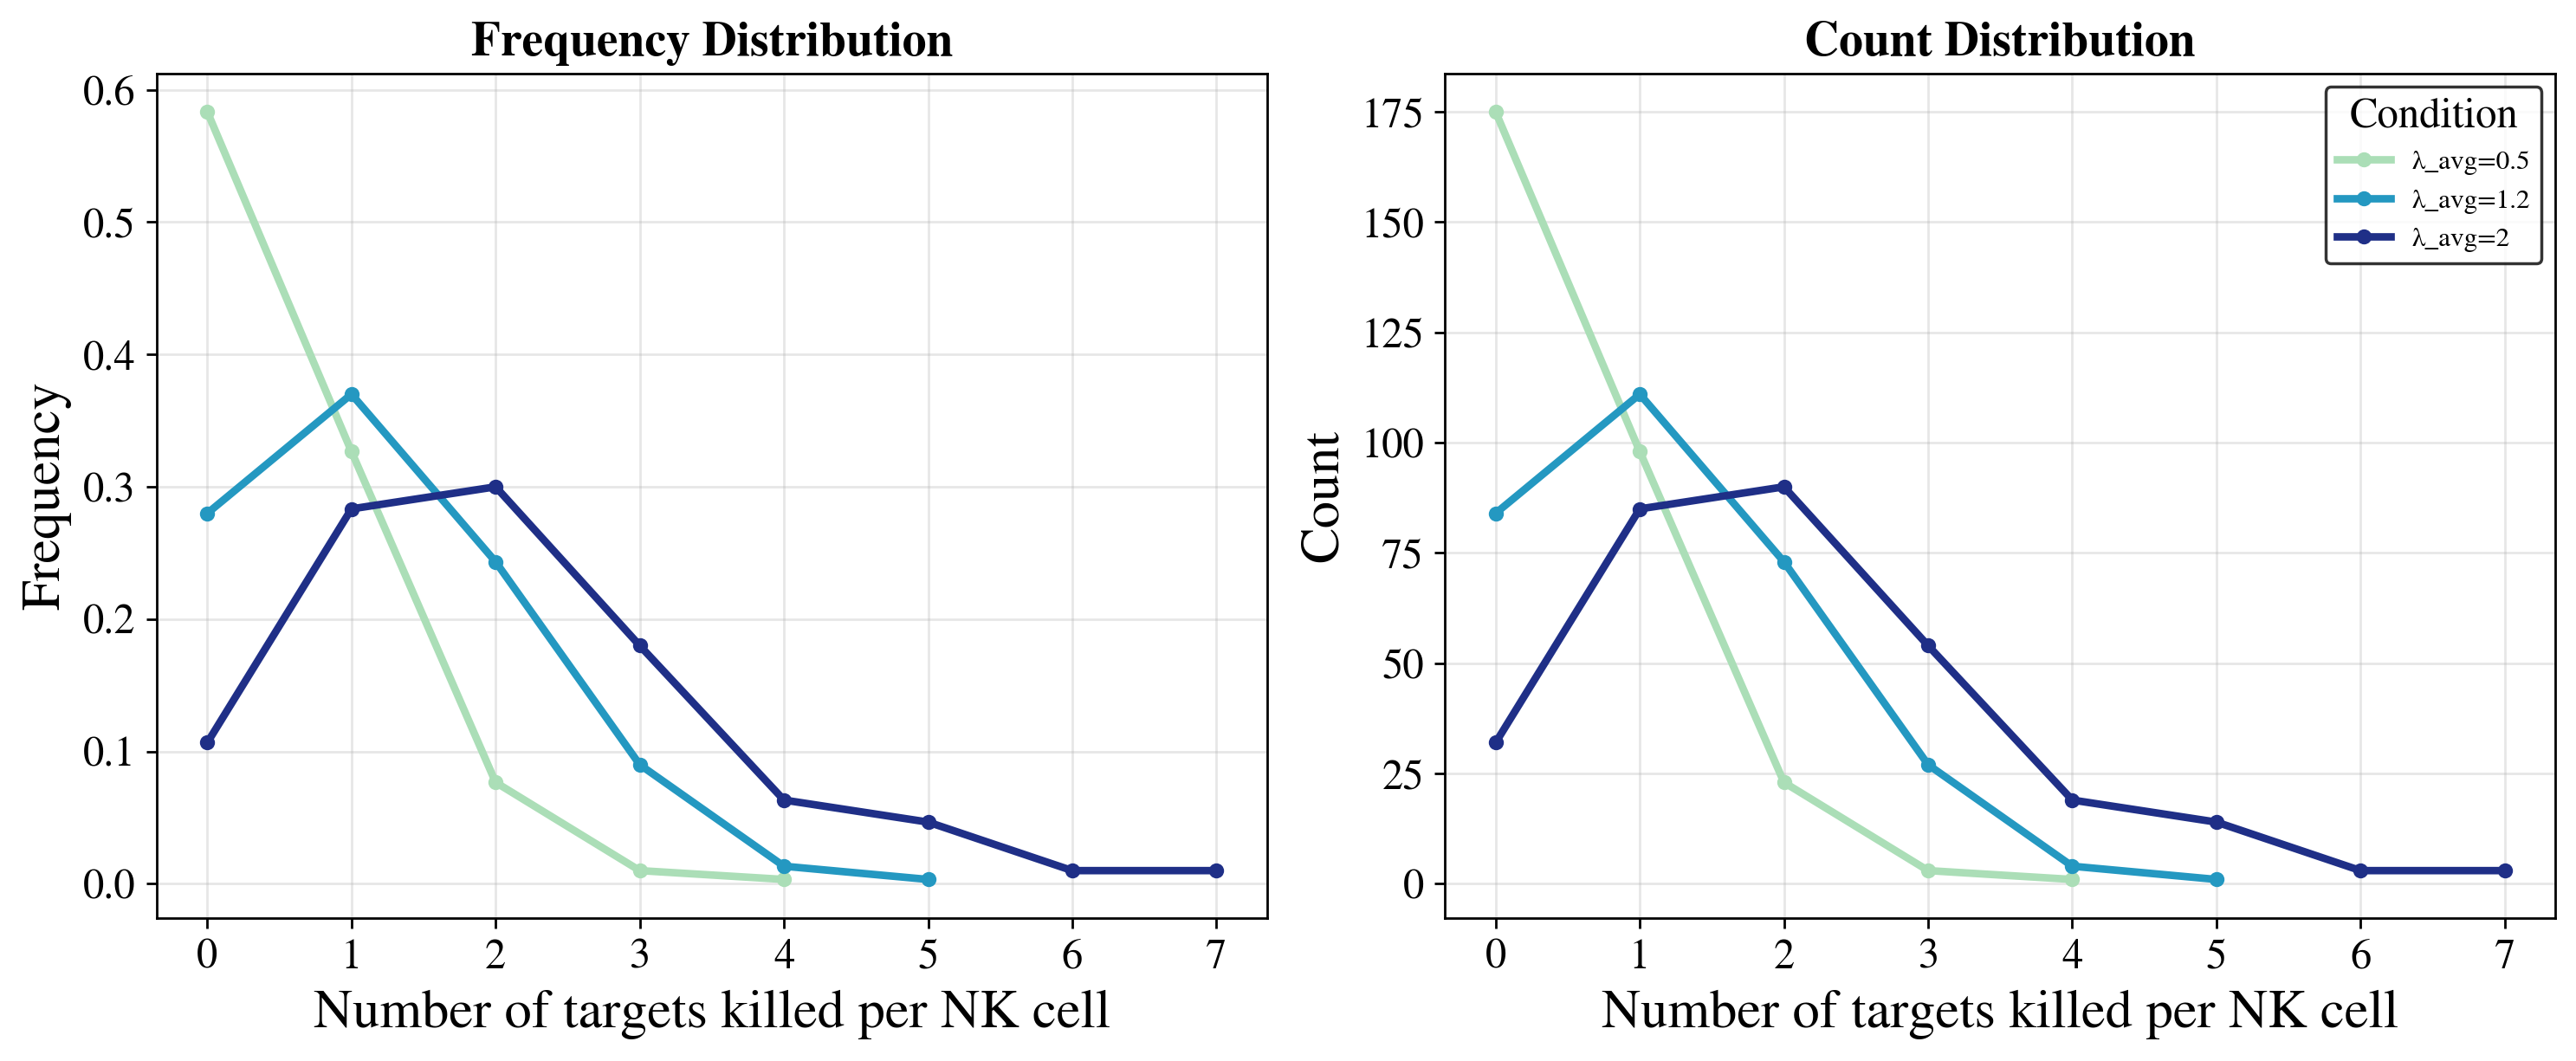

In [9]:
conditions = [
    f"λ_avg={lambda_list[i]}" 
    for i in range(len(lambda_list))
]

cmap = get_cmap('YlGnBu')
colors = cmap(np.linspace(0.3, 0.9, len(conditions)))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5), dpi=250, sharex=True)
ax_freq, ax_count = axes

for i, cond_name in enumerate(conditions):
    colour = colors[i]
    
    kills = experiment[i].get_summary()['kills']
    n_cells = len(kills)
    max_kills = int(kills.max())
    counts = np.bincount(kills, minlength=max_kills + 1)
    freq = counts / n_cells if n_cells > 0 else np.zeros_like(counts)
    x = np.arange(len(counts))
    
    ax_freq.plot(x, freq, color=colour, linewidth=2.5, label=cond_name, marker='o', markersize=4)
    ax_count.plot(x, counts, color=colour, linewidth=2.5, label=cond_name, marker='o', markersize=4)

ax_freq.set_title("Frequency Distribution", fontweight='bold')
ax_count.set_title("Count Distribution", fontweight='bold')
ax_freq.set_ylabel("Frequency")
ax_count.set_ylabel("Count")

for ax in (ax_freq, ax_count):
    ax.set_xlabel("Number of targets killed per NK cell")
    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.grid(True, alpha=0.3)

ax_count.legend(title="Condition", frameon=True, edgecolor='black', loc='upper right', fontsize=9)
plt.tight_layout()
# plt.savefig("./synthetic_data_plots.pdf", dpi=500, bbox_inches="tight")
plt.show()


**One parameter ($\lambda$)** Bayesian inference for estimating the parameter ($\lambda$) value.

In [12]:
def inference_one_i(kills_per_cell_array, draws=3000, tune=3000, chains=4, seed=None):
    M = len(kills_per_cell_array)
    with pm.Model() as model:
        eta = pm.Uniform("eta", lower=-3.0, upper=3.0)  
        lam = pm.Deterministic("lam", 10.0 ** eta)
        pm.Poisson("K", mu=lam, observed=kills_per_cell_array)
        idata = pm.sample(
            draws=draws, tune=tune, chains=chains,
            target_accept=0.9, random_seed=seed, progressbar=True)
        try:
            idata = pm.compute_log_likelihood(idata, extend_inferencedata=True)
        except Exception:
            pass
    return idata

def inference_all_i(experiment, labels=None, draws=3000, tune=3000, chains=4, seed=None):
    if labels is None:
        labels = [f"cond_{i}" for i in range(len(experiment))]

    out = []
    for i in tqdm(range(len(experiment))):
        current_seed = seed + i if seed is not None else None
        idata = inference_one_i(
            kills_per_cell_array=experiment[i].get_summary()['kills'],
            draws=draws,
            tune=tune,
            chains=chains,
            seed=current_seed
        )
        out.append((labels[i], idata))
    return out

In [13]:
conditions = [
    f"λ_avg={lambda_list[i]}" 
    for i in range(len(lambda_list))
]
ground_truth_values = {}
for i, cond_label in enumerate(conditions):
    ground_truth_values[cond_label] = {
        "mu_lambda": experiment[i].kill_lambda,
    }   


idatas = inference_all_i(
    experiment=list(experiment.values()),
    labels=conditions,
    draws=3000,
    tune=3000,
    chains=4,
    seed=None
)

  0%|          | 0/3 [00:00<?, ?it/s]Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eta]
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eta]


/opt/homebrew/Caskroom/miniforge/base/envs/snake/lib/python3.13/site-packages/rich/live.py:256: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 3_000 tune and 3_000 draw iterations (12_000 + 12_000 draws total) took 1 seconds.


/opt/homebrew/Caskroom/miniforge/base/envs/snake/lib/python3.13/site-packages/rich/live.py:256: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

 33%|███▎      | 1/3 [00:12<00:25, 12.70s/it]Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eta]
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eta]


/opt/homebrew/Caskroom/miniforge/base/envs/snake/lib/python3.13/site-packages/rich/live.py:256: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 3_000 tune and 3_000 draw iterations (12_000 + 12_000 draws total) took 1 seconds.


/opt/homebrew/Caskroom/miniforge/base/envs/snake/lib/python3.13/site-packages/rich/live.py:256: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

 67%|██████▋   | 2/3 [00:13<00:05,  5.96s/it]Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eta]
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eta]


/opt/homebrew/Caskroom/miniforge/base/envs/snake/lib/python3.13/site-packages/rich/live.py:256: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 3_000 tune and 3_000 draw iterations (12_000 + 12_000 draws total) took 1 seconds.


/opt/homebrew/Caskroom/miniforge/base/envs/snake/lib/python3.13/site-packages/rich/live.py:256: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

100%|██████████| 3/3 [00:15<00:00,  5.06s/it]


λ_avg=0.5: mean = 0.523, HDI = [0.437, 0.6]
λ_avg=1.2: mean = 1.2, HDI = [1.08, 1.32]
λ_avg=2: mean = 2.04, HDI = [1.88, 2.2]
Saved PDF: ./rate_posteriors_facet.pdf
Saved PDF: ./rate_posteriors_facet.pdf


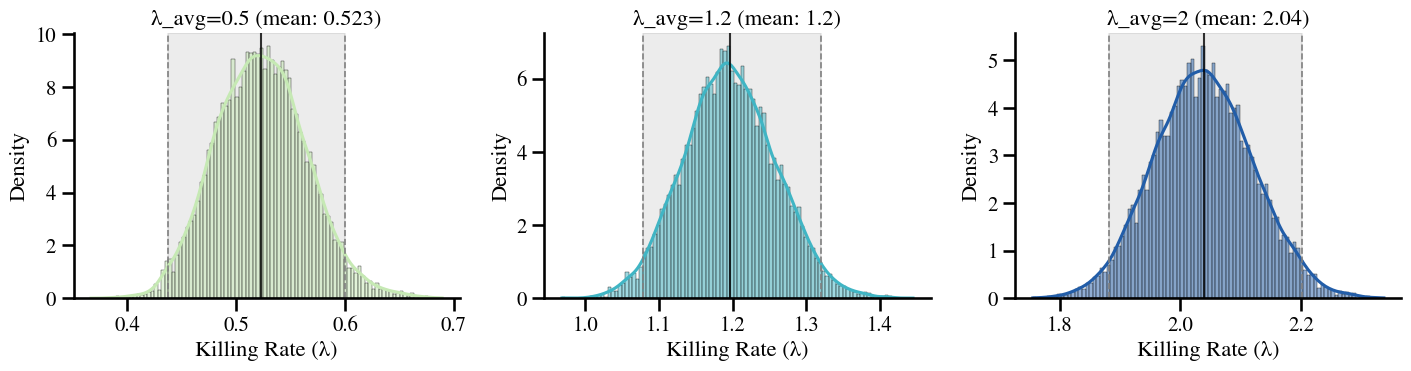

λ_avg=0.5: mean = 0.523, HDI = [0.437, 0.6]
λ_avg=1.2: mean = 1.2, HDI = [1.08, 1.32]
λ_avg=2: mean = 2.04, HDI = [1.88, 2.2]
Saved PDF: ./rate_posteriors_kde.pdf


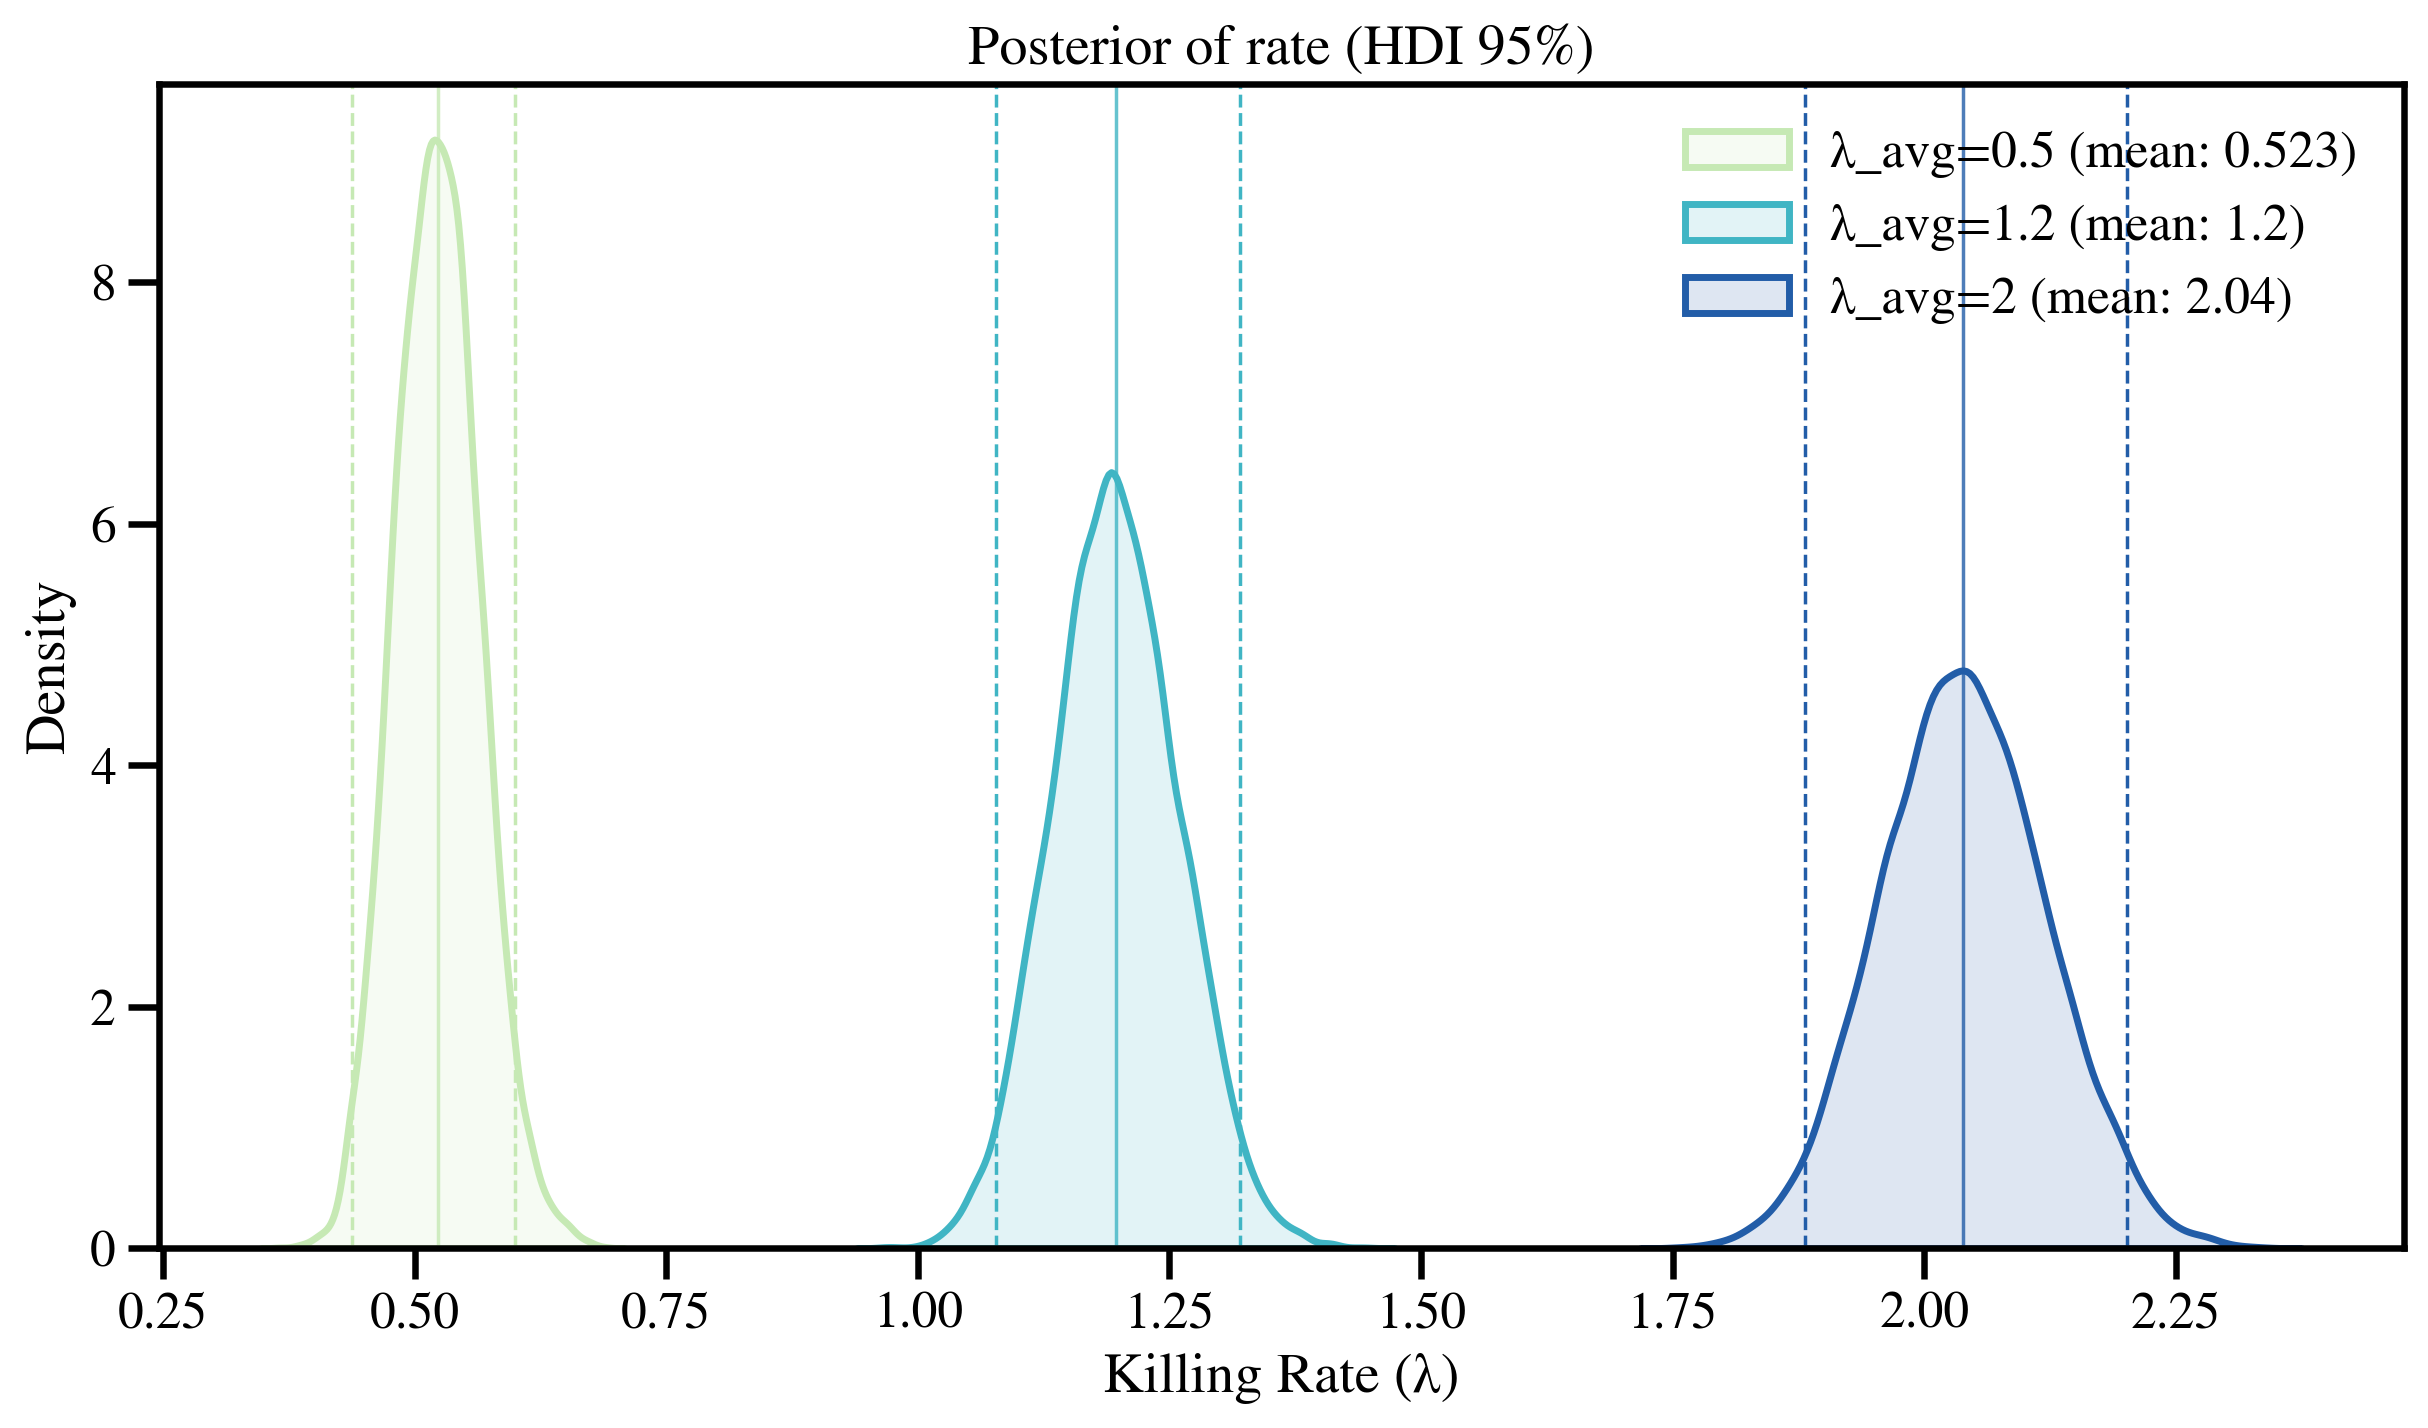

In [14]:
def plot_lam_posteriors(
    idatas,
    style="kde",              # "kde", "hist", or "facet"
    hdi_prob=0.95,
    export_pdf=False,
    pdf_path="lam_posteriors.pdf",
    bins=100,
    density=False,            # True=normalised density; False=counts
    show_mean=True,
    legend_show_mean=True,    # <-- put posterior mean in legend text
    legend_fmt=".3g",         # <-- format for the mean in legend
    legend_loc="best",        # <-- where to place the legend
):
    """
    idatas: list of (label, idata) as returned by inference_all_i()
    style : "kde" for overlaid density curves; "hist" for overlaid histograms; "facet" for separate subplots
    """
    # Collect posterior draws of lam into a tidy DataFrame
    frames, order = [], []
    for label, idata in idatas:
        lam_da = idata.posterior["lam"]  # dims ('chain','draw')
        lam_vals = lam_da.stack(sample=("chain", "draw")).values.astype(float).ravel()
        frames.append(pd.DataFrame({"lam": lam_vals, "label": label}))
        order.append(label)
    all_df = pd.concat(frames, ignore_index=True)

    # HDIs & posterior means per label
    hdi_map = {}
    mean_map = {}
    for lab in order:
        vals = all_df.loc[all_df["label"] == lab, "lam"].to_numpy()
        hdi_map[lab] = tuple(az.hdi(vals, hdi_prob=hdi_prob))
        mean_map[lab] = float(np.mean(vals))
        print(f"{lab}: mean = {format(mean_map[lab], legend_fmt)}, HDI = [{format(hdi_map[lab][0], legend_fmt)}, {format(hdi_map[lab][1], legend_fmt)}]")

    # Helper to make legend text
    def _legend_label(lab):
        if legend_show_mean:
            return f"{lab} (mean: {format(mean_map[lab], legend_fmt)})"
        return lab

    sns.set_context("talk", font_scale=0.9)
    palette = sns.color_palette("YlGnBu", n_colors=len(order))

    if style.lower() == "kde":
        # -------- Overlaid KDEs --------
        fig, ax = plt.subplots(figsize=(10, 6), dpi=250)
        for c, lab in zip(palette, order):
            sdf = all_df.loc[all_df["label"] == lab]
            sns.kdeplot(data=sdf, x="lam", ax=ax, linewidth=2, color=c,
                        label=_legend_label(lab), fill=True, alpha=0.15)
            lo, hi = hdi_map[lab]
            ax.axvline(lo, color=c, linestyle="--", linewidth=1)
            ax.axvline(hi, color=c, linestyle="--", linewidth=1)
            if show_mean:
                ax.axvline(mean_map[lab], color=c, linestyle="-", linewidth=1, alpha=0.8)

        ax.set_xlabel("Killing Rate (λ)")
        ax.set_ylabel("Density")
        ax.set_title(f"Posterior of rate (HDI {int(hdi_prob*100)}%)")
        ax.legend(frameon=False, loc=legend_loc)

    elif style.lower() == "hist":
        # -------- Overlaid histograms on ONE axis --------
        fig, ax = plt.subplots(figsize=(10, 6), dpi=150)
        rmin, rmax = all_df["lam"].min(), all_df["lam"].max()
        span = (rmax - rmin) or 1e-6
        rmin, rmax = rmin - 0.02 * span, rmax + 0.02 * span
        edges = np.linspace(rmin, rmax, bins + 1)

        for c, lab in zip(palette, order):
            vals = all_df.loc[all_df["label"] == lab, "lam"].to_numpy()
            # filled translucent + outline for readability
            ax.hist(vals, bins=edges, density=density, histtype="stepfilled",
                    alpha=0.18, color=c, label=None)
            ax.hist(vals, bins=edges, density=density, histtype="step",
                    linewidth=1.8, color=c, label=_legend_label(lab))

            # HDI shading and lines
            lo, hi = hdi_map[lab]
            ax.axvspan(lo, hi, color=c, alpha=0.08, linewidth=0)
            ax.axvline(lo, color=c, linestyle="--", linewidth=1)
            ax.axvline(hi, color=c, linestyle="--", linewidth=1)
            if show_mean:
                ax.axvline(mean_map[lab], color=c, linestyle="-", linewidth=1, alpha=0.9)

        ax.set_xlabel("Killing Rate (λ)")
        ax.set_ylabel("Density" if density else "Count")
        ax.set_title(f"Posterior of rate — overlaid histograms (HDI {int(hdi_prob*100)}%)")
        ax.legend(frameon=False, loc=legend_loc)
        
    elif style.lower() == "facet":
        # -------- Faceted histograms --------
        g = sns.FacetGrid(all_df, col="label", col_wrap=min(3, len(order)),
                          hue="label", palette=palette, sharex=False, sharey=False,
                          height=4, aspect=1.2)
        g.map(sns.histplot, "lam", bins=bins, stat="density" if density else "count", kde=True)

        for ax, lab in zip(g.axes.flat, g.col_names):
            lo, hi = hdi_map[lab]
            ax.axvspan(lo, hi, color='grey', alpha=0.15, zorder=0)
            ax.axvline(lo, color='grey', linestyle="--", linewidth=1.2)
            ax.axvline(hi, color='grey', linestyle="--", linewidth=1.2)
            if show_mean:
                ax.axvline(mean_map[lab], color='black', linestyle="-", linewidth=1.5, alpha=0.8)
            ax.set_title(_legend_label(lab))
            ax.set_xlabel("Killing Rate (λ)")
            if density:
                ax.set_ylabel("Density")
            else:
                ax.set_ylabel("Count")
        fig = g.fig
        
    else:
        raise ValueError(f"Unknown style: '{style}'. Choose 'kde', 'hist', or 'facet'.")


    plt.tight_layout()
    if export_pdf:
        fig.savefig(pdf_path, dpi=300, bbox_inches="tight")
        print(f"Saved PDF: {pdf_path}")
    plt.show()

# Plot posterior distributions of the inferred rates
plot_lam_posteriors(
    idatas, style="facet", hdi_prob=0.95, density = True,
    export_pdf=True, pdf_path="./rate_posteriors_facet.pdf"
)
plot_lam_posteriors(
    idatas, style="kde", hdi_prob=0.95, density = True,
    export_pdf=True, pdf_path="./rate_posteriors_kde.pdf"
)

In [ ]:
def plot_lam_posteriors(
    idatas,
    style="kde",              # "kde", "hist", or "facet"
    hdi_prob=0.95,
    export_pdf=False,
    pdf_path="lam_posteriors.pdf",
    bins=500,
    density=True,            # True=normalised density; False=counts
    show_mean=True,
    legend_show_mean=False,    # <-- put posterior mean in legend text
    legend_fmt=".3g",         # <-- format for the mean in legend
    legend_loc="best",        # <-- where to place the legend
):
    frames, order = [], []
    for label, idata in idatas:
        lam_da = idata.posterior["lam"]  # dims ('chain','draw')
        lam_vals = lam_da.stack(sample=("chain", "draw")).values.astype(float).ravel()
        frames.append(pd.DataFrame({"lam": lam_vals, "label": label}))
        order.append(label)
    all_df = pd.concat(frames, ignore_index=True)

    hdi_map = {}
    mean_map = {}
    for lab in order:
        vals = all_df.loc[all_df["label"] == lab, "lam"].to_numpy()
        hdi_map[lab] = tuple(az.hdi(vals, hdi_prob=hdi_prob))
        mean_map[lab] = float(np.mean(vals))
        print(f"{lab}: mean = {format(mean_map[lab], legend_fmt)}, HDI = [{format(hdi_map[lab][0], legend_fmt)}, {format(hdi_map[lab][1], legend_fmt)}]")

    def _legend_label(lab):
        if legend_show_mean:
            return f"{lab} (mean: {format(mean_map[lab], legend_fmt)})"
        return lab

    sns.set_context("talk", font_scale=0.9)
    palette = sns.color_palette("YlGnBu", n_colors=len(order))

    if style.lower() == "kde":
        fig, ax = plt.subplots(figsize=(10, 6), dpi=250)
        for c, lab in zip(palette, order):
            sdf = all_df.loc[all_df["label"] == lab]
            sns.kdeplot(data=sdf, x="lam", ax=ax, linewidth=2, color=c,
                        label=_legend_label(lab), fill=True, alpha=0.15)
            lo, hi = hdi_map[lab]
            ax.axvline(lo, color=c, linestyle="--", linewidth=1)
            ax.axvline(hi, color=c, linestyle="--", linewidth=1)
            if show_mean:
                ax.axvline(mean_map[lab], color=c, linestyle="-", linewidth=1, alpha=0.8)

        ax.set_xlabel("Killing Rate (λ)")
        ax.set_ylabel("Density")
        ax.set_title(f"Posterior of rate (HDI {int(hdi_prob*100)}%)")
        ax.legend(frameon=False, loc=legend_loc)

    elif style.lower() == "hist":
        fig, ax = plt.subplots(figsize=(10, 6), dpi=150)
        rmin, rmax = all_df["lam"].min(), all_df["lam"].max()
        span = (rmax - rmin) or 1e-6
        rmin, rmax = rmin - 0.02 * span, rmax + 0.02 * span
        edges = np.linspace(rmin, rmax, bins + 1)

        for c, lab in zip(palette, order):
            vals = all_df.loc[all_df["label"] == lab, "lam"].to_numpy()
            ax.hist(vals, bins=edges, density=density, histtype="stepfilled",
                    alpha=0.18, color=c, label=None)
            ax.hist(vals, bins=edges, density=density, histtype="step",
                    linewidth=1.8, color=c, label=_legend_label(lab))
            lo, hi = hdi_map[lab]
            ax.axvspan(lo, hi, color=c, alpha=0.08, linewidth=0)
            ax.axvline(lo, color=c, linestyle="--", linewidth=1)
            ax.axvline(hi, color=c, linestyle="--", linewidth=1)
            if show_mean:
                ax.axvline(mean_map[lab], color=c, linestyle="-", linewidth=1, alpha=0.9)

        ax.set_xlabel("Killing Rate (λ)")
        ax.set_ylabel("Density" if density else "Count")
        ax.set_title(f"Posterior of rate — overlaid histograms (HDI {int(hdi_prob*100)}%)")
        ax.legend(frameon=False, loc=legend_loc)
        
    elif style.lower() == "facet":
        g = sns.FacetGrid(all_df, col="label", col_wrap=min(3, len(order)),
                          hue="label", palette=palette, sharex=False, sharey=False,
                          height=4, aspect=1.2)
        g.map(sns.histplot, "lam", bins=bins, stat="density" if density else "count", kde=True)

        for ax, lab in zip(g.axes.flat, g.col_names):
            lo, hi = hdi_map[lab]
            ax.axvspan(lo, hi, color='grey', alpha=0.15, zorder=0)
            ax.axvline(lo, color='grey', linestyle="--", linewidth=1.2)
            ax.axvline(hi, color='grey', linestyle="--", linewidth=1.2)
            if show_mean:
                ax.axvline(mean_map[lab], color='black', linestyle="-", linewidth=1.5, alpha=0.8)
            ax.set_title(_legend_label(lab))
            ax.set_xlabel("Killing Rate (λ)")
            if density:
                ax.set_ylabel("Density")
            else:
                ax.set_ylabel("Count")
        fig = g.fig
        
    else:
        raise ValueError(f"Unknown style: '{style}'. Choose 'kde', 'hist', or 'facet'.")


    plt.tight_layout()
    if export_pdf:
        fig.savefig(pdf_path, dpi=300, bbox_inches="tight")
        print(f"Saved PDF: {pdf_path}")
    plt.show()

# Plot posterior distributions of the inferred rates
plot_lam_posteriors(
    idatas, style="facet", hdi_prob=0.95, density = True,
    export_pdf=True, pdf_path="./rate_posteriors_facet.pdf"
)
plot_lam_posteriors(
    idatas, style="kde", hdi_prob=0.95, density = True,
    export_pdf=True, pdf_path="./rate_posteriors_kde.pdf"
)